In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [51]:
# Загрузка данных
data_train = pd.read_csv('train.csv', parse_dates=['Date'], index_col='Date')
data_test = pd.read_csv('test.csv', parse_dates=['Date'], index_col='Date')

In [73]:
# Удаление дубликатов
data_train = data_train[~data_train.index.duplicated(keep='first')]
data_test = data_test[~data_test.index.duplicated(keep='first')]

In [53]:
# Установка частоты индекса
data_train = data_train.asfreq('D')
data_test = data_test.asfreq('D')

In [54]:
data_train.head()

,store,product,number_sold
Date,,,
2010-01-01,0,0,801
2010-01-02,0,0,810
2010-01-03,0,0,818
2010-01-04,0,0,796
2010-01-05,0,0,808


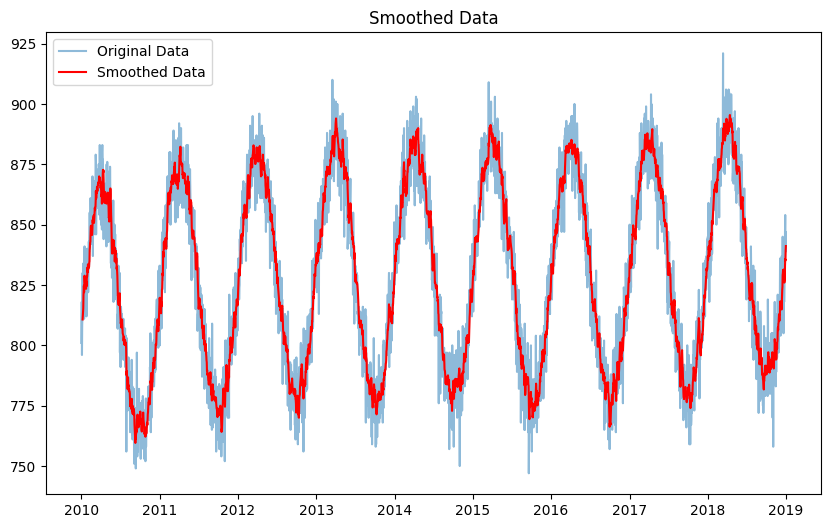

In [55]:
# 1. Сглаживание данных (скользящее среднее)
data_train['number_sold_smoothed'] = data_train['number_sold'].rolling(window=7).mean()
plt.figure(figsize=(10, 6))
plt.plot(data_train['number_sold'], alpha=0.5, label='Original Data')
plt.plot(data_train['number_sold_smoothed'], label='Smoothed Data', color='red')
plt.legend()
plt.title('Smoothed Data')
plt.show()

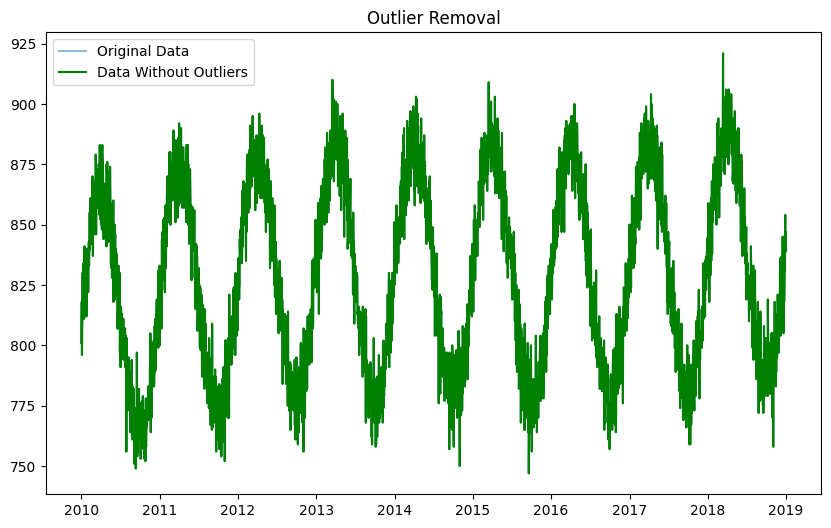

In [56]:
# 2. Удаление выбросов
Q1 = data_train['number_sold'].quantile(0.25)
Q3 = data_train['number_sold'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data_train_no_outliers = data_train[(data_train['number_sold'] >= lower_bound) & (data_train['number_sold'] <= upper_bound)]

plt.figure(figsize=(10, 6))
plt.plot(data_train['number_sold'], alpha=0.5, label='Original Data')
plt.plot(data_train_no_outliers['number_sold'], label='Data Without Outliers', color='green')
plt.legend()
plt.title('Outlier Removal')
plt.show()

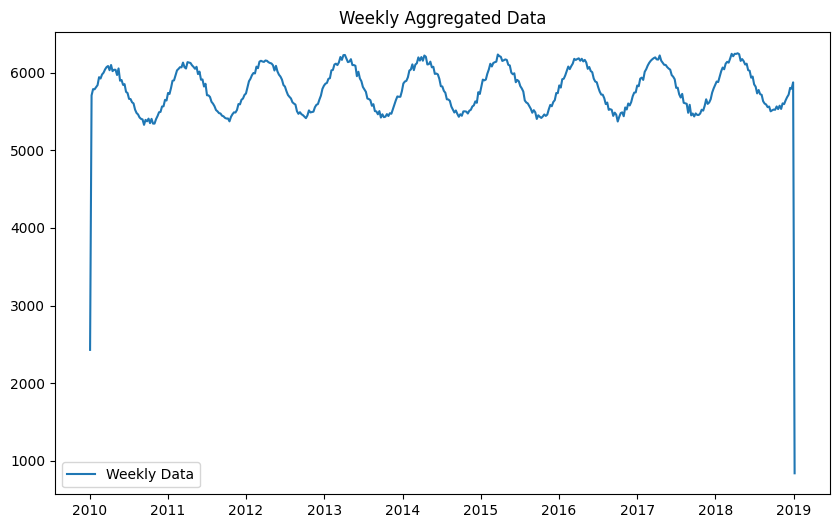

In [57]:
# 3. Агрегация данных на недельной основе
data_train_weekly = data_train_no_outliers['number_sold'].resample('W').sum()
plt.figure(figsize=(10, 6))
plt.plot(data_train_weekly, label='Weekly Data')
plt.title('Weekly Aggregated Data')
plt.legend()
plt.show()

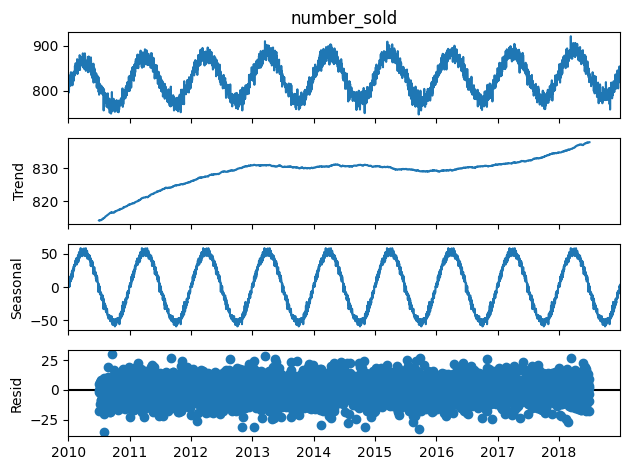

In [58]:
# 4. Декомпозиция временного ряда
decomposition = seasonal_decompose(data_train_no_outliers['number_sold'], model='additive', period=365)
decomposition.plot()
plt.show()

In [59]:
# Применяем разности
data_train_diff = data_train['number_sold'].diff().dropna()

In [60]:
# Проверяем стационарность после разностей
result_diff = adfuller(data_train_diff)
print(f"ADF Statistic (после разностей): {result_diff[0]}")
print(f"p-value (после разностей): {result_diff[1]}")
if result_diff[1] > 0.05:
    print("Ряд всё ещё не стационарен. Возможно, потребуется дополнительное преобразование.")
else:
    print("Ряд стационарен. Можно использовать для моделирования.")

ADF Statistic (после разностей): -5.6042478511436995
p-value (после разностей): 1.2446461152847318e-06
Ряд стационарен. Можно использовать для моделирования.


In [62]:
# SARIMA модель
sarima_model = SARIMAX(
    data_train_diff,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        number_sold   No. Observations:                 3286
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -12783.016
Date:                            Thu, 19 Dec 2024   AIC                          25576.033
Time:                                    10:16:18   BIC                          25606.479
Sample:                                01-02-2010   HQIC                         25586.938
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5020      0.015    -32.436      0.000      -0.532      -0.472
ma.L1         -1.0000      1.353   

In [63]:
# Прогнозирование SARIMA
sarima_forecast = sarima_fit.forecast(steps=len(data_test))
sarima_forecast_cumsum = sarima_forecast.cumsum() + data_train['number_sold'].iloc[-1]

In [61]:
# ARIMA модель
arima_model = ARIMA(data_train_diff, order=(1, 1, 1))
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                 3286
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12855.809
Date:                Thu, 19 Dec 2024   AIC                          25717.619
Time:                        10:15:48   BIC                          25735.910
Sample:                    01-02-2010   HQIC                         25724.168
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5040      0.015    -32.730      0.000      -0.534      -0.474
ma.L1         -0.9999      0.037    -26.904      0.000      -1.073      -0.927
sigma2       146.4116      6.414     22.827      0.0

In [64]:
# Прогнозирование ARIMA
arima_forecast = arima_fit.forecast(steps=len(data_test))
arima_forecast_cumsum = arima_forecast.cumsum() + data_train['number_sold'].iloc[-1]

In [66]:
# Оценка качества SARIMA
sarima_mape = mean_absolute_percentage_error(data_test['number_sold'], sarima_forecast_cumsum)
sarima_mse = mean_squared_error(data_test['number_sold'], sarima_forecast_cumsum)
sarima_rmse = np.sqrt(sarima_mse)
sarima_r2 = r2_score(data_test['number_sold'], sarima_forecast_cumsum)

print(f"SARIMA MAPE: {sarima_mape}")
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"SARIMA R^2: {sarima_r2}")

SARIMA MAPE: 0.03731295620444346
SARIMA RMSE: 36.86259567227893
SARIMA R^2: -0.06739496801083056


In [67]:
# Оценка качества ARIMA
arima_mape = mean_absolute_percentage_error(data_test['number_sold'], arima_forecast_cumsum)
arima_mse = mean_squared_error(data_test['number_sold'], arima_forecast_cumsum)
arima_rmse = np.sqrt(arima_mse)
arima_r2 = r2_score(data_test['number_sold'], arima_forecast_cumsum)

print(f"ARIMA MAPE: {arima_mape}")
print(f"ARIMA RMSE: {arima_rmse}")
print(f"ARIMA R^2: {arima_r2}")

ARIMA MAPE: 0.03780712019978563
ARIMA RMSE: 37.127051369341885
ARIMA R^2: -0.08276508625243517


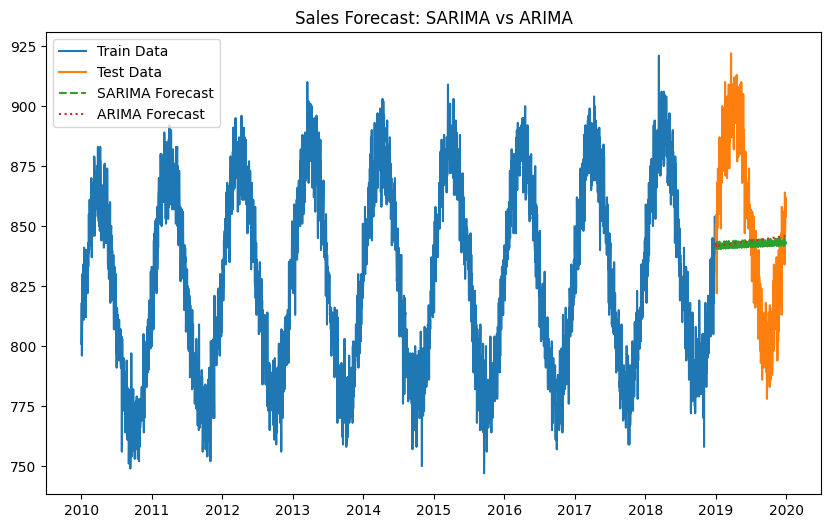

In [68]:
# Визуализация прогноза
plt.figure(figsize=(10, 6))
plt.plot(data_train['number_sold'], label='Train Data')
plt.plot(data_test['number_sold'], label='Test Data')
plt.plot(data_test.index, sarima_forecast_cumsum, label='SARIMA Forecast', linestyle='--')
plt.plot(data_test.index, arima_forecast_cumsum, label='ARIMA Forecast', linestyle=':')
plt.title('Sales Forecast: SARIMA vs ARIMA')
plt.legend()
plt.show()

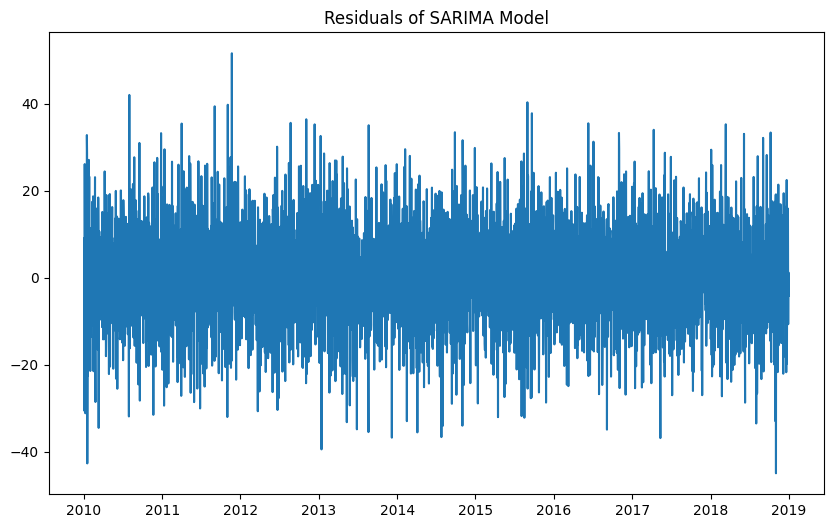

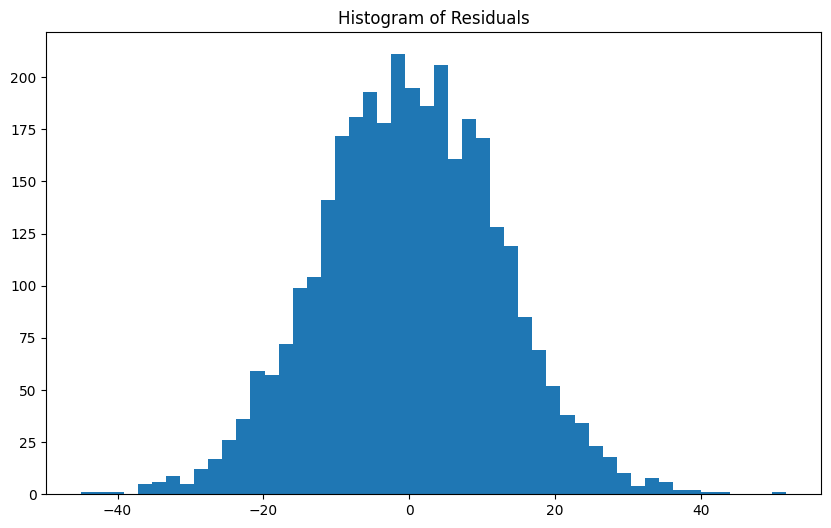

In [70]:
# Анализ остатков SARIMA
residuals = sarima_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50)
plt.title('Histogram of Residuals')
plt.show()

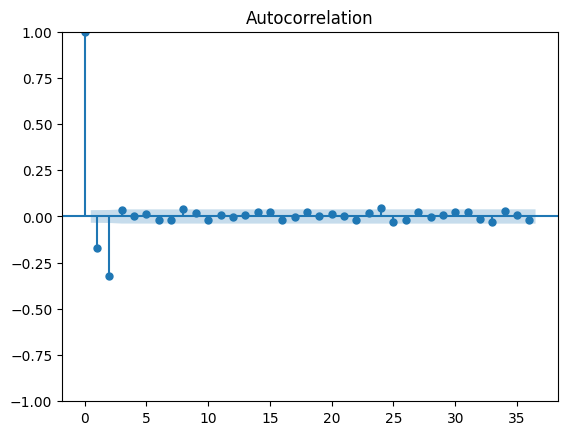

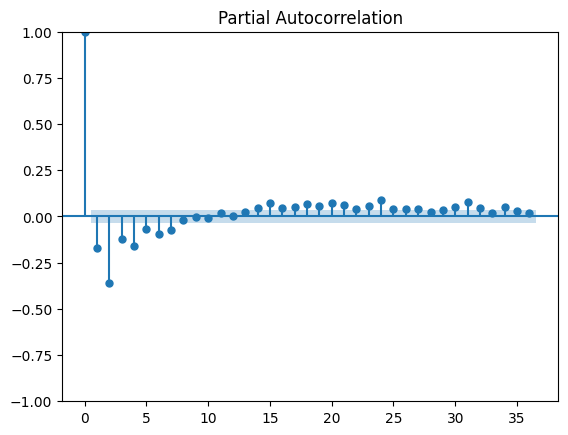

In [71]:
# Автокорреляция и частичная автокорреляция остатков
plot_acf(residuals)
plt.show()

plot_pacf(residuals)
plt.show()